Try lowering the accuracy of the DE output so FAN2 gets misclassified more.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import nengo
from nengo.utils.numpy import rmse
import nengo_spa as spa

from nengo_learn_assoc_mem.utils import make_alt_vocab, VecToScalarFeed, gen_added_strings

import random

In [15]:
def choose_encoders(n_neurons: int, dimensions: int, encoder_proportion: float, mean_fan1, mean_fan2):
    encoders = np.zeros((n_neurons, dimensions))

    fan1_end = int(n_neurons * encoder_proportion)

    for n_i in range(fan1_end):
        encoders[n_i] = mean_fan1 + np.random.normal(size=dimensions)*0.1

    for n_i in range(fan1_end, n_neurons):
        encoders[n_i] = mean_fan2 + np.random.normal(size=dimensions)*0.1
    
    return encoders

In [16]:
dimensions = 32
n_neurons = 500
seed = 8
p_fan = 0.85

n_items = 5

t_present = 0.3
t_pause = 0.6
t_each = t_pause + t_present
dt = 0.001

In [17]:
vocab, fan1, fan1_pair_vecs, fan2, fan2_pair_vecs, foil1, foil1_pair_vecs, foil2, foil2_pair_vecs = make_alt_vocab(n_items, n_items, dimensions, seed, norm=True)
encoders = choose_encoders(n_neurons, dimensions, p_fan, np.mean(fan1_pair_vecs, axis=0), np.mean(fan2_pair_vecs, axis=0))

In [18]:
all_fan = fan1 + fan2
all_fan_pairs = gen_added_strings(all_fan)

all_vecs = fan1_pair_vecs + fan2_pair_vecs + foil1_pair_vecs + foil2_pair_vecs

target_ans = [1] * (len(fan1) + len(fan2))
foil_ans = [-1] * (len(foil1) + len(foil2))
all_ans = target_ans + foil_ans

In [19]:
with nengo.Network(seed=seed) as model:
    ens = nengo.Ensemble(n_neurons, dimensions, encoders=encoders, seed=seed)
sim = nengo.Simulator(model)

Building finished in 0:00:01.                                                   


In [20]:
_, fan1_act = nengo.utils.ensemble.tuning_curves(ens, sim, inputs=np.array(fan1_pair_vecs))
_, fan2_act = nengo.utils.ensemble.tuning_curves(ens, sim, inputs=np.array(fan2_pair_vecs))

In [21]:
solver = nengo.solvers.LstsqL2()

In [22]:
fan_acts = np.concatenate((fan1_act, fan2_act))
fan_vecs = np.concatenate((np.array(fan1_pair_vecs), np.array(fan2_pair_vecs)))

In [23]:
fan_dec, fan_stats = solver(fan_acts, fan_vecs)
res = np.dot(fan_acts, fan_dec)
print(res.shape)
print(rmse(res, fan_vecs, axis=1).shape)
print(np.sum(rmse(res, fan_vecs, axis=1)))

(10, 32)
(10,)
0.0428227675563787


In [24]:
print("FAN1 RMSE", np.sum(rmse(res[:len(fan1)], fan_vecs[:len(fan1)], axis=1)))
print("FAN2 RMSE", np.sum(rmse(res[len(fan1):], fan_vecs[len(fan1):], axis=1)))

FAN1 RMSE 0.016586440353222764
FAN2 RMSE 0.026236327203155926


In [25]:
noise_acts = np.concatenate((fan1_act, fan2_act+np.random.normal(size=fan2_act.shape)*20))
f2_vecs = np.array(fan2_pair_vecs)
noise_vecs = np.concatenate((np.array(fan1_pair_vecs), f2_vecs+np.random.normal(size=f2_vecs.shape)*0))

In [26]:
noise_dec, fan_stats = solver(noise_acts, noise_vecs)
res = np.dot(fan_acts, noise_dec)
print(res.shape)
print(rmse(res, fan_vecs, axis=1).shape)
print(np.sum(rmse(res, fan_vecs, axis=1)))

(10, 32)
(10,)
0.2370764904160313


In [27]:
print("FAN1 RMSE", np.sum(rmse(res[:len(fan1)], fan_vecs[:len(fan1)], axis=1)))
print("FAN2 RMSE", np.sum(rmse(res[len(fan1):], fan_vecs[len(fan1):], axis=1)))

FAN1 RMSE 0.01818378845719299
FAN2 RMSE 0.2188927019588383


## Base Case

In [29]:
feed = VecToScalarFeed(all_vecs, all_ans, t_present, t_pause)

with spa.Network(seed=seed) as base_model:
    model.famili = nengo.Node(feed.feed)
    model.correct = nengo.Node(feed.get_answer)
    model.reset = nengo.Node(lambda t: feed.paused)

    model.designed_ensemble = nengo.Ensemble(n_neurons, dimensions, encoders=encoders, seed=seed)

    # Low time-scale definitely works better for FAN2 and the slow connection doesn't really do anything
    model.cleanup = spa.IAAssocMem(input_vocab=vocab,
                                   mapping=dict(zip(all_fan_pairs, all_fan_pairs)))
    
    nengo.Connection(model.famili, model.designed_ensemble, synapse=None)
    nengo.Connection(model.designed_ensemble.neurons, model.cleanup.input, transform=fan_dec.T)
    nengo.Connection(model.reset, model.cleanup.input_reset, synapse=None)
    
    p_in = nengo.Probe(model.famili, synapse=None, label="input")
    p_de = nengo.Probe(model.cleanup.input, synapse=0.01, label="de_out")
    p_clean = nengo.Probe(model.cleanup.output, synapse=0.01, label="clean")

In [30]:
with nengo.Simulator(base_model) as base_sim:
    base_sim.run(len(all_vecs)*(t_present+t_pause) + t_pause)

t_range = base_sim.trange()

Building finished in 0:00:01.                                                   
Simulating finished in 0:01:03.                                                 


In [31]:
fan1_win = slice(int(t_pause / dt), int((len(fan1) * t_each + t_pause) / dt))
fan2_win = slice(fan1_win.stop, fan1_win.stop + int((len(fan2) * t_each) / dt))
foil1_win = slice(fan2_win.stop, fan2_win.stop + int((len(foil1) * t_each) / dt))
foil2_win = slice(foil1_win.stop, foil1_win.stop + int((len(foil2) * t_each) / dt))

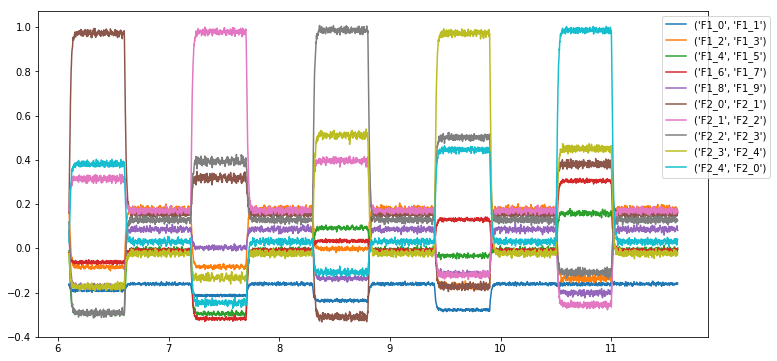

In [32]:
plt.figure(figsize=(12, 6))
plt.plot(t_range[fan2_win], spa.similarity(base_sim.data[p_de], fan1_pair_vecs+fan2_pair_vecs)[fan2_win])
plt.legend(fan1+fan2, bbox_to_anchor=(1.1, 1))

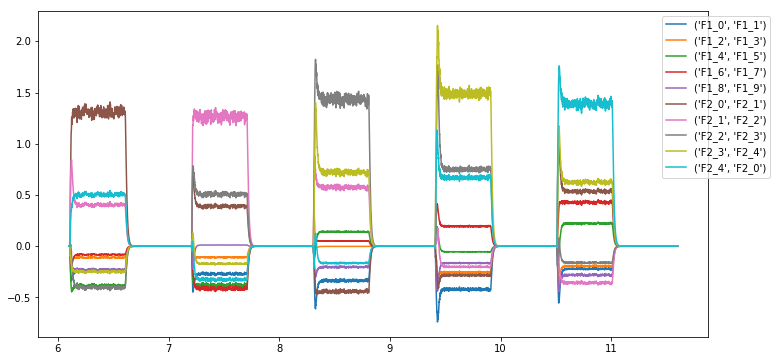

In [34]:
plt.figure(figsize=(12, 6))
plt.plot(t_range[fan2_win], spa.similarity(base_sim.data[p_clean], fan1_pair_vecs+fan2_pair_vecs)[fan2_win])
plt.legend(fan1+fan2, bbox_to_anchor=(1.1, 1))

## Higher Error Rate

In [40]:
feed = VecToScalarFeed(all_vecs, all_ans, t_present, t_pause)

with nengo.Network(seed=seed) as noise_model:
    model.famili = nengo.Node(feed.feed)
    model.correct = nengo.Node(feed.get_answer)
    model.reset = nengo.Node(lambda t: feed.paused)

    model.designed_ensemble = nengo.Ensemble(n_neurons, dimensions, encoders=encoders)

    # Low time-scale definitely works better for FAN2 and the slow connection doesn't really do anything
    model.cleanup = spa.IAAssocMem(input_vocab=vocab,
                                   mapping=dict(zip(all_fan_pairs, all_fan_pairs)))
    
    nengo.Connection(model.famili, model.designed_ensemble, synapse=None)
    nengo.Connection(model.designed_ensemble.neurons, model.cleanup.input, transform=noise_dec.T)
    nengo.Connection(model.reset, model.cleanup.input_reset, synapse=None)
    
    p_in = nengo.Probe(model.famili, synapse=None, label="input")
    p_de = nengo.Probe(model.cleanup.input, synapse=0.01, label="de_out")
    p_clean = nengo.Probe(model.cleanup.output, synapse=0.01, label="clean")

In [41]:
with nengo.Simulator(noise_model) as sim_noise:
    sim_noise.run(len(all_vecs)*(t_present+t_pause) + t_pause)

t_range = sim_noise.trange()

Building finished in 0:00:01.                                                   
Simulating finished in 0:01:00.                                                 


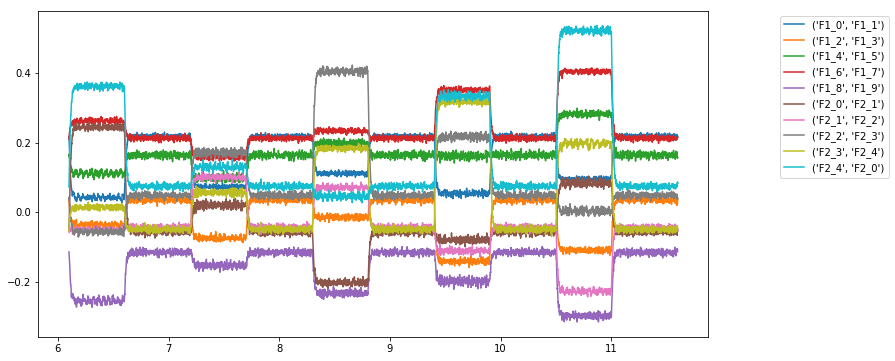

In [42]:
plt.figure(figsize=(12, 6))
plt.plot(t_range[fan2_win], spa.similarity(sim_noise.data[p_de], fan1_pair_vecs+fan2_pair_vecs)[fan2_win])
plt.legend(fan1+fan2, bbox_to_anchor=(1.1, 1))

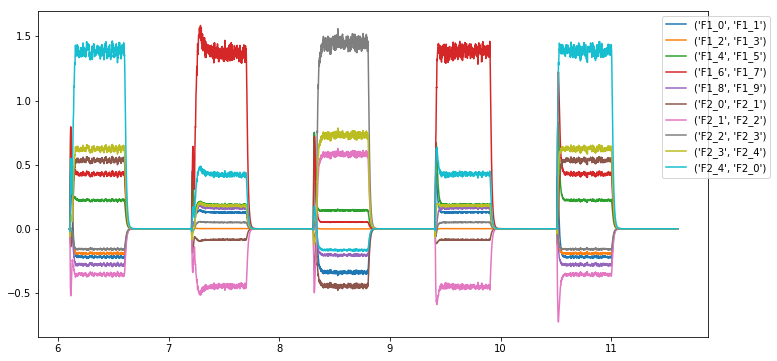

In [43]:
plt.figure(figsize=(12, 6))
plt.plot(t_range[fan2_win], spa.similarity(sim_noise.data[p_clean], fan1_pair_vecs+fan2_pair_vecs)[fan2_win])
plt.legend(fan1+fan2, bbox_to_anchor=(1.1, 1))

## Make a function that prints out the error rate, so you can plug it into Hyperopt to get an exact noise level